# Agentic System Implementation

#### The Fine-Tuned was downloaded from my Google Drive, zipped and saved for use with the Agentic System. The Google Colab Note book shows the steps from installing the libraries and importing the necessary libraries. Then we went ahead to unzip the model, load it to Google Colab along with the base model, Tokenizers and Adapters. The knowledge base is also uploaded to the Colab environment, and then the Agentic System is implemented. The step by step process is stated below

In [ ]:
# Install the required Python libraries for LLM inference, PEFT, evaluation (BLEU, ROUGE), PDF processing, and UI via Gradio.

In [1]:
!pip install datasets transformers bitsandbytes accelerate peft torch safetensors faiss-cpu chardet trl tensorboard gradio rank_bm25 pymupdf sentence-transformers rouge-score
!pip install pdfplumber

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00


In [ ]:
# Import the Libraries

In [2]:
# Import libraries
from google.colab import files
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from sentence_transformers import SentenceTransformer, util
import torch
import zipfile
import os
import fitz  # PyMuPDF
import faiss
from rank_bm25 import BM25Okapi
import numpy as np
import gradio as gr
from huggingface_hub import login
import pandas as pd
import spacy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import pdfplumber
from pathlib import Path
from peft import PeftModel, PeftConfig
import random
from huggingface_hub import login


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Upload the zipped model to Google colab and unzip

In [ ]:
#File Upload the Zipped Fine-Tuned Model for unzipping

In [3]:
uploaded = files.upload()

Saving fine-tuned-llama-3.2-3B_instruct-1.zip to fine-tuned-llama-3.2-3B_instruct-1.zip


In [ ]:
# Setting the Path of the ZIP File and the Extracting the ZIP file

In [4]:
zip_path = "/content/fine-tuned-llama-3.2-3B_instruct-1.zip"
extract_dir = "unzipped_model"
os.makedirs(extract_dir, exist_ok = True)

In [5]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
print(f' Successfully extracted model to {extract_dir}')

 Successfully extracted model to unzipped_model


In [ ]:
 # Hugging Face Authentication & Model Loading

login("HF_TOKEN")

# Local LoRA adapter path
adapter_path = "/content/unzipped_model/content/drive/MyDrive/fine-tuned-llama-3.2-3B_instruct-1"

# Load adapter config
peft_config = PeftConfig.from_pretrained(adapter_path)

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto",
    token="HF_TOKEN"
)

# Apply LoRA adapter
model = PeftModel.from_pretrained(base_model, adapter_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    peft_config.base_model_name_or_path,
    token="HF_TOKEN"
)
tokenizer.pad_token = tokenizer.eos_token


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [7]:
# Load Sentence-BERT Model for Semantic Search.
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Upload the knowledge base.
uploaded = files.upload()

Saving knowledge_base.zip to knowledge_base.zip


In [9]:

# Extract PDFs from uploaded ZIP.

zip_path = 'knowledge_base.zip'
unzip_folder = '/content/pdf_folder'  # Folder to extract ZIP content into


# Unzip the top-level ZIP file
os.makedirs(unzip_folder, exist_ok=True)  # Create the output folder if it doesn't exist

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder)  # Extract content of the ZIP

In [10]:
# Extract text from PDFs
documents = []
document_sources = []

for root, _, files in os.walk(unzip_folder):
    for filename in files:
        if filename.lower().endswith('.pdf'):
            pdf_path = os.path.join(root, filename)
            doc = fitz.open(pdf_path)
            text = "".join([page.get_text() for page in doc])
            documents.append(text)
            document_sources.append(filename)

print(f"Loaded {len(documents)} documents from PDFs.")

Loaded 12 documents from PDFs.


#### Sentence-BERT is used generates semantic embeddings for each document and then converts those embeddings from a PyTorch tensor into a NumPy array. This conversion is necessary to prepare the embeddings for use in FAISS, which enables fast and meaningful document retrieval based on semantic similarity.

In [11]:
# Compute document embeddings for semantic search

doc_embeddings = sentence_model.encode(documents, convert_to_tensor=True)
document_embeddings_np = doc_embeddings.cpu().detach().numpy()

# Setup FAISS index

dimension = document_embeddings_np.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(document_embeddings_np)

#### BM25Okapi is initialized with a tokenized version of the corpus. It ranks documents based on the presence and frequency of keywords from the user’s query, serving as a traditional keyword-based retrieval system to complement semantic search.

In [12]:
#Initialize BM25 retriever
tokenized_corpus = [doc.lower().split() for doc in documents]
bm25 = BM25Okapi(tokenized_corpus)

####  A hybrid retrieval function combines the results from both FAISS (semantic) and BM25 (keyword) systems. The function selects the top-scoring documents from each method and merges them, enhancing the relevance and diversity of the retrieved content for more accurate downstream responses.

In [13]:
#Existing hybrid retrieval function (unchanged for reference)
def retrieve_documents_hybrid(query, top_k=3, alpha=0.5, faiss_index=faiss_index, bm25=bm25):
    try:
        tokenized_query = query.lower().split()
        bm25_scores = bm25.get_scores(tokenized_query)
        query_embedding = sentence_model.encode(query, convert_to_tensor=True).cpu().detach().numpy()
        _, faiss_indices = faiss_index.search(np.array([query_embedding]), k=len(documents))

        # Normalize scores
        bm25_scores = np.array(bm25_scores)
        bm25_scores = (bm25_scores - bm25_scores.min()) / (bm25_scores.max() - bm25_scores.min() + 1e-8)

        faiss_scores = np.zeros(len(documents))
        for rank, idx in enumerate(faiss_indices[0]):
            faiss_scores[idx] = 1 / (rank + 1)  # Simple decay

        # Hybrid scoring
        hybrid_scores = alpha * bm25_scores + (1 - alpha) * faiss_scores
        top_indices = np.argsort(hybrid_scores)[-top_k:][::-1]

        return [documents[i] for i in top_indices]
    except Exception as e:
        print(f"Error in retrieve_documents_hybrid: {e}")
        return []

#### A relevance scoring function computes cosine similarity between the query and each retrieved document and calculates keyword overlap. This helps assess how well each document matches the user’s intent, supporting better decision-making on whether to retrieve or generate answers.

In [14]:
# Evaluate relevance using cosine similarity and content coverage
def evaluate_relevance(query, retrieved_docs):
    try:
        if not retrieved_docs:
            return 0.0
        query_embedding = sentence_model.encode(query, convert_to_tensor=True)
        doc_embeddings = sentence_model.encode(retrieved_docs, convert_to_tensor=True)
        # Average cosine similarity
        cos_sim = util.pytorch_cos_sim(query_embedding, doc_embeddings).mean().item()
        # Content coverage: Check if retrieved documents contain query keywords
        query_tokens = set(query.lower().split())
        coverage_scores = []
        for doc in retrieved_docs:
            doc_tokens = set(doc.lower().split())
            coverage = len(query_tokens.intersection(doc_tokens)) / len(query_tokens) if query_tokens else 0.0
            coverage_scores.append(coverage)
        avg_coverage = np.mean(coverage_scores) if coverage_scores else 0.0
        # Combine cosine similarity and coverage (weighted)
        return 0.7 * cos_sim + 0.3 * avg_coverage
    except Exception as e:
        print(f"Error in evaluate_relevance: {e}")
        return 0.0

####  The agentic decision-making layer analyzes the user’s query to determine how the system should respond—either by retrieving relevant documents, generating a response from scratch, or combining both. It first checks whether the query includes course-related keywords such as "assessment", "syllabus", or "Teesside University", suggesting the need for retrieval. Then it calculates the semantic similarity between the query and the document embeddings using cosine similarity. If the query is contextually close to any document or contains relevant keywords, the system retrieves documents using a hybrid method. Based on how well those documents match the query, it decides whether to just retrieve and generate, or retrieve and enhance. If no strong matches are found, the model will choose to generate a response from scratch.

In [15]:
# Agentic decision-making layer
def agent_decision(query, doc_embeddings):
    try:
        # Improved keyword list for course-related queries
        keywords = [
            "define", "explain", "what is", "list", "teesside university",
            "assessment", "course", "module", "syllabus", "learning outcome",
            "curriculum", "structure", "msc", "computer science", "data science"
        ]
        query_lower = query.lower()
        needs_retrieval = any(keyword in query_lower for keyword in keywords)

        # Additional heuristic: Check query similarity to document embeddings
        query_embedding = sentence_model.encode(query, convert_to_tensor=True)
        doc_similarities = util.pytorch_cos_sim(query_embedding, doc_embeddings).cpu().numpy()
        max_doc_similarity = np.max(doc_similarities) if doc_similarities.size > 0 else 0.0

        # Trigger retrieval if keywords are present or query is similar to documents
        if needs_retrieval or max_doc_similarity > 0.5:
            retrieved_docs = retrieve_documents_hybrid(query, top_k=3, alpha=0.5)
            retrieval_quality = evaluate_relevance(query, retrieved_docs)
            # Adjusted threshold for retrieval quality
            if retrieval_quality < 0.65 or not retrieved_docs:
                return "retrieve_and_enhance", retrieved_docs
            return "retrieve_and_generate", retrieved_docs
        return "generate_from_scratch", []
    except Exception as e:
        print(f"Error in agent_decision: {e}")
        return "generate_from_scratch", []

#### The generate_response_with_llama3 function uses the fine-tuned Llama-3 model to generate a detailed and structured response. It constructs a context-aware prompt that incorporates retrieved documents when available. If enhance is enabled, the prompt instructs the model to blend retrieved context with general knowledge, ensuring factual accuracy even when the documents are partial or weak. If not, the model is directed to strictly use the provided context. The prompt is then tokenized and passed to the model for generation. Output is decoded, cleaned, and returned.

In [16]:

# Generate response using fine-tuned LLaMA model with improved prompt
def generate_response_with_llama3(query, retrieved_docs, enhance=False):
    try:
        retrieved_context = "\n".join(retrieved_docs) if retrieved_docs else "No relevant context available."
        # Enhanced prompt with clear instructions
        if enhance:
            prompt = (
                f"Context (may be incomplete or partially relevant):\n{retrieved_context}\n\n"
                f"Question: {query}\n\n"
                f"Instructions: Provide a detailed and accurate response to the question. Use the provided context if relevant, "
                f"but supplement with general knowledge if the context is insufficient. Ensure the response is coherent, "
                f"factually correct, and avoids fabricating details not supported by the context. "
                f"Structure the response clearly with sections if applicable.\n\n"
                f"Answer: "
            )
        else:
            prompt = (
                f"Context:\n{retrieved_context}\n\n"
                f"Question: {query}\n\n"
                f"Instructions: Generate a response based on the provided context. Ensure the response is accurate, "
                f"directly addresses the question, and avoids adding information not supported by the context. "
                f"Structure the response clearly with sections if applicable.\n\n"
                f"Answer: "
            )

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=300, padding=True).to(model.device)
        outputs = model.generate(
            inputs['input_ids'],
            max_length=512,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            temperature=0.7,
            top_p=0.85
        )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Clean up response to remove prompt prefix
        response = response.split("Answer:")[-1].strip() if "Answer:" in response else response
        return response
    except Exception as e:
        print(f"Error in generate_response_with_llama3: {e}")
        return "Error generating response."

#### The merge_responses function combines the generated answer with a summarized view of the documents used in retrieval. If no documents were retrieved, it simply returns the generated text. Otherwise, it formats a readable response that includes both the main answer and brief source excerpts. This promotes transparency and credibility, allowing users to see which sources informed the answer, especially valuable in academic or knowledge-based applications.

In [17]:

# Merge retrieved documents and generated response for enhanced responses
def merge_responses(retrieved_docs, generated_text):
    try:
        if not retrieved_docs:
            return generated_text
        # Summarize retrieved documents for concise integration
        retrieved_summary = "\n".join([f"- {doc[:100]}..." for doc in retrieved_docs])
        return (
            f"Response:\n{generated_text}\n\n"
            f"Source Information (Summarized):\n{retrieved_summary}"
        )
    except Exception as e:
        print(f"Error in merge_responses: {e}")
        return generated_text



 The agent_workflow function orchestrates the full intelligent response pipeline. It first invokes the agentic decision layer to determine whether the user’s query should trigger document retrieval, retrieval plus enhancement, or a full generation from scratch. Based on this decision, it routes the query accordingly:

For general or unsupported queries, it uses the LLaMA model alone to generate a standalone response.

If relevant documents are retrieved, it either generates a response grounded in those documents or enhances the retrieved content with additional model knowledge.

When enhancement is applied, it merges the generated response with a summarized view of the sources, ensuring both clarity and transparency.

This function is the central logic controller that enables adaptive, context-aware behavior, reflecting the "agentic" intelligence of the system.

In [18]:
# Full agentic workflow
def agent_workflow(query, doc_embeddings):
    try:
        action, retrieved_docs = agent_decision(query, doc_embeddings)
        print(f"Agent Decision: {action}")

        if action == "generate_from_scratch":
            return generate_response_with_llama3(query, [], enhance=False)
        elif action == "retrieve_and_generate":
            return generate_response_with_llama3(query, retrieved_docs, enhance=False)
        else:  # retrieve_and_enhance
            # Use retrieved documents with enhancement instructions
            enhanced_response = generate_response_with_llama3(query, retrieved_docs, enhance=True)
            return merge_responses(retrieved_docs, enhanced_response)
    except Exception as e:
        print(f"Error in agent_workflow: {e}")
        return "Error processing query."

In [19]:
# Create Gradio interface
interface = gr.Interface(
    fn=agent_workflow,
    inputs="text",
    outputs="text",
    title="Agentic System for Course Planning and Development",
    description="Ask the agent a question, and it will retrieve relevant information and generate a response.")

/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1018: UserWarning: Expected 2 arguments for function <function agent_workflow at 0x79dc906c16c0>, received 1.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1022: UserWarning: Expected at least 2 arguments for function <function agent_workflow at 0x79dc906c16c0>, received 1.
  warnings.warn(


In [20]:
#Launch the interface (comment out if not running interactively)
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://79a1d48c6109bdf9a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Link to a recorded test video

# https://www.loom.com/share/42d803547e454518995ba68d6e32cbc8?sid=508d2e03-995a-4b60-9add-7ff7ee025511

## Evaluation of Perplexity, Cosine Similarity, BLEU and Rouge

#### The set_seed function sets a fixed random seed across Python, NumPy, and PyTorch. This ensures that model behavior, data shuffling, and other stochastic processes produce consistent results across different runs.

In [ ]:
# Set random seed for reproducibility
def set_seed(seed=42):
    """Set random seed for reproducibility across runs."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:

# Load spaCy model for tokenization
nlp = spacy.load("en_core_web_sm")

# Load sentence transformer model
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Authenticate with Hugging Face
login("HF_TOKEN")

# Define adapter path (use the unzipped location)
adapter_path = "/content/unzipped_model/content/drive/MyDrive/fine-tuned-llama-3.2-3B_instruct-1"

# Verify adapter path exists
if not os.path.exists(adapter_path):
    raise FileNotFoundError(f"Adapter path {adapter_path} does not exist. Please check the path.")
expected_files = ["adapter_config.json", "adapter_model.safetensors"]
for f in expected_files:
    if not os.path.exists(os.path.join(adapter_path, f)):
        raise FileNotFoundError(f"Required file {f} not found in {adapter_path}")

# Load adapter config
peft_config = PeftConfig.from_pretrained(adapter_path)

# Load base model
try:
    base_model = AutoModelForCausalLM.from_pretrained(
        peft_config.base_model_name_or_path,  # Should be "meta-llama/Llama-3.2-3B-Instruct"
        torch_dtype=torch.float16,
        device_map="auto",
        token="HF_TOKEN"
    )
except Exception as e:
    raise RuntimeError(f"Failed to load base model: {e}")

# Apply LoRA adapter
model = PeftModel.from_pretrained(base_model, adapter_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    peft_config.base_model_name_or_path,
    token="HF_TOKEN"
)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_text(text):
    """Tokenize text into words using spaCy."""
    doc = nlp(text.lower())
    return [token.text for token in doc if not token.is_punct]

def compute_perplexity(prompt, response, device="cuda" if torch.cuda.is_available() else "cpu"):
    """Compute perplexity of the response given the prompt using LLaMA."""
    if model is None or tokenizer is None:
        return float('inf')

    try:
        inputs = tokenizer(prompt + " " + response, return_tensors="pt", truncation=True, max_length=512).to(device)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

        perplexity = torch.exp(loss).item()
        return perplexity
    except Exception as e:
        print(f"Error computing perplexity: {e}")
        return float('inf')

def generate_response_with_llama3(prompt, device="cuda" if torch.cuda.is_available() else "cpu"):
    """Generate response using the fine-tuned LLaMA model."""
    if model is None or tokenizer is None:
        return "Model or tokenizer not loaded."

    try:
        # Set seed before generation for reproducibility
        set_seed(42)
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model.generate(
            **inputs,
            max_length=512,  # Increased for longer responses
            num_return_sequences=1,
            temperature=0.7,
            do_sample=True
        )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response
    except Exception as e:
        print(f"Error generating response: {e}")
        return ""

def evaluate_metrics(prompt, generated_response=None, ground_truth=None, use_generated_response=False):
    """
    Evaluate Perplexity, Cosine Similarity, BLEU, and ROUGE for provided inputs.

    Args:
        prompt (str): Input prompt
        generated_response (str, optional): Provided response; ignored if use_generated_response=True
        ground_truth (str): Reference response
        use_generated_response (bool): If True, generate response with LLaMA

    Returns:
        dict: Contains scores
    """
    if not prompt or not ground_truth:
        print("Prompt and ground truth must be provided.")
        return None

    try:
        # Generate response if requested
        if use_generated_response:
            generated_response = generate_response_with_llama3(prompt)
        elif not generated_response:
            print("Generated response must be provided if use_generated_response=False.")
            return None

        results = {}

        # Perplexity for ground truth and generated response
        perplexity_gt = compute_perplexity(prompt, ground_truth)
        perplexity_gen = compute_perplexity(prompt, generated_response)
        results['Perplexity_Ground_Truth'] = perplexity_gt
        results['Perplexity_Generated'] = perplexity_gen

        # Cosine Similarity
        prompt_emb = sentence_model.encode(prompt, convert_to_tensor=True)
        response_emb = sentence_model.encode(generated_response, convert_to_tensor=True)
        cos_sim = util.pytorch_cos_sim(prompt_emb, response_emb).cpu().numpy().item()
        results['Cosine_Similarity'] = cos_sim

        # BLEU
        reference_tokens = [tokenize_text(ground_truth)]
        generated_tokens = tokenize_text(generated_response)
        smoothie = SmoothingFunction().method4
        bleu = sentence_bleu(
            reference_tokens,
            generated_tokens,
            weights=(0.25, 0.25, 0.25, 0.25),
            smoothing_function=smoothie
        )
        results['BLEU'] = bleu

        # ROUGE
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(ground_truth, generated_response)
        results['ROUGE1'] = rouge_scores['rouge1'].fmeasure
        results['ROUGE2'] = rouge_scores['rouge2'].fmeasure
        results['ROUGEL'] = rouge_scores['rougeL'].fmeasure

        # Print results
        print(f"Prompt: {prompt[:100]}...")
        print(f"Generated: {generated_response[:100]}...")
        print(f"Ground Truth: {ground_truth[:100]}...")
        print(f"Perplexity (Generated): {perplexity_gen:.2f}")
        print(f"Cosine Similarity: {cos_sim:.4f}")
        print(f"BLEU: {bleu:.4f}")
        print(f"ROUGE-1: {rouge_scores['rouge1'].fmeasure:.4f}")
        print(f"ROUGE-2: {rouge_scores['rouge2'].fmeasure:.4f}")
        print(f"ROUGE-L: {rouge_scores['rougeL'].fmeasure:.4f}")
        print("-" * 50)

        # Save results
        result_df = pd.DataFrame([{
            'Prompt': prompt,
            'Generated_Response': generated_response,
            'Ground_Truth': ground_truth,
            'Perplexity_Ground_Truth': perplexity_gt,
            'Perplexity_Generated': perplexity_gen,
            'Cosine_Similarity': cos_sim,
            'BLEU': bleu,
            'ROUGE1': rouge_scores['rouge1'].fmeasure,
            'ROUGE2': rouge_scores['rouge2'].fmeasure,
            'ROUGEL': rouge_scores['rougeL'].fmeasure
        }])
        #result_df.to_excel("evaluation_results.xlsx", index=False)
        print(f"Results saved to evaluation_results.xlsx")

        return results

    except Exception as e:
        print(f"Error evaluating metrics: {e}")
        return None

def main():
    # Example inputs
    prompt = "Explain the learning outcomes for Machine Learning (CIS4035-N)."
    ground_truth = """Learning Outcomes for Machine Learning (CIS4035-N):
               - Apply supervised and unsupervised machine learning algorithms to real-world datasets.
               - Evaluate model performance using appropriate metrics and validation techniques.
               - Design machine learning pipelines for data preprocessing and feature engineering.
               - Critically analyze the ethical and societal impacts of machine learning applications."""

    # Evaluate metrics using generated response
    use_generated_response = True
    results = evaluate_metrics(
        prompt=prompt,
        generated_response=None,  # Ignored since use_generated_response=True
        ground_truth=ground_truth,
        use_generated_response=use_generated_response
    )

    if results is not None:
        print("Successfully evaluated metrics")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Prompt: Explain the learning outcomes for Machine Learning (CIS4035-N)....
Generated: Explain the learning outcomes for Machine Learning (CIS4035-N). 
Develop a deep understanding of the...
Ground Truth: Learning Outcomes for Machine Learning (CIS4035-N):
               - Apply supervised and unsupervis...
Perplexity (Generated): 2.48
Cosine Similarity: 0.7806
BLEU: 0.0578
ROUGE-1: 0.3128
ROUGE-2: 0.1148
ROUGE-L: 0.2275
--------------------------------------------------
Results saved to evaluation_results.xlsx
Successfully evaluated metrics


## Evaluation of Hallucination Rate

In [ ]:


# Load SentenceTransformer
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Provided data
query = "Explain the learning outcomes for the Machine Learning (CIS4035-N)"
generated_response = """Answer This machine learning curriculum prepares students to
build and deploy sophisticated algorithms that can analyze complex data sets. Students
will study key concepts including supervised models, unsupervised methods, machine learning
for computer vision, natural language processing, recommender systems, deep learning, as well
as the theory behind these algorithms. The curriculum will also cover the machine design process,
model evaluation, data preprocessing, feature engineering, deployment, ethical considerations,
business applications, security, privacy, bias, fairness, transparency, diversity, inclusion,
big data, cloud computing, distributed computing."""

retrieved_docs = ["""You are an academic assistant helping to plan and refine course section
structures based on Teesside University guidelines. Use the context below to answer the question
clearly. Be brief for simple questions and elaborate where needed. Context: Teesside University
Course Specification Guide, MSc Computer Science course. Question: Explain the learning outcomes
for the Machine Learning (CIS4035-N) section?
Answer: Learning Outcomes for Machine Learning (CIS4035-N):
- Apply supervised and unsupervised machine learning algorithms to real-world datasets.
- Evaluate model performance using appropriate metrics and validation techniques.
- Design machine learning pipelines for data preprocessing and feature engineering.
- Critically analyze the ethical and societal impacts of machine learning applications."""]

# Function to compute hallucination metric
def compute_hallucination_metric(query, retrieved_docs, generated_response, similarity_threshold=0.6):
    """
    Compute hallucination metric by checking if generated response contains information
    not supported by retrieved documents.

    Args:
        query (str): Input query
        retrieved_docs (list): List of retrieved document texts
        generated_response (str): Generated response from the model
        similarity_threshold (float): Minimum cosine similarity for a sentence to be considered grounded

    Returns:
        dict: Contains hallucination rate and details
    """
    try:
        #Tokenize generated response into sentences
        response_sentences = sent_tokenize(generated_response)

        # Encode retrieved documents and response sentences
        doc_embeddings = sentence_model.encode(retrieved_docs, convert_to_tensor=True)
        response_embeddings = sentence_model.encode(response_sentences, convert_to_tensor=True)

        # Compute cosine similarity between each response sentence and retrieved documents
        hallucinated_sentences = []
        grounded_sentences = []

        for i, resp_emb in enumerate(response_embeddings):
            similarities = util.pytorch_cos_sim(resp_emb.unsqueeze(0), doc_embeddings).cpu().numpy()
            max_similarity = np.max(similarities)

            if max_similarity < similarity_threshold:
                hallucinated_sentences.append({
                    'sentence': response_sentences[i],
                    'max_similarity': max_similarity
                })
            else:
                grounded_sentences.append({
                    'sentence': response_sentences[i],
                    'max_similarity': max_similarity
                })

        # Compute hallucination rate
        total_sentences = len(response_sentences)
        hallucination_count = len(hallucinated_sentences)
        hallucination_rate = hallucination_count / total_sentences if total_sentences > 0 else 0.0

        # Return results
        return {
            'hallucination_rate': hallucination_rate,
            'hallucinated_sentences': hallucinated_sentences,
            'grounded_sentences': grounded_sentences,
            'total_sentences': total_sentences
        }
    except Exception as e:
        print(f"Error in compute_hallucination_metric: {e}")
        return {
            'hallucination_rate': 0.0,
            'hallucinated_sentences': [],
            'grounded_sentences': [],
            'total_sentences': 0
        }

# Evaluate hallucination for a single query
def evaluate_hallucination_single(query, retrieved_docs, generated_response, similarity_threshold=0.6):
    """
    Evaluate hallucination metric for a single query.

    Args:
        query (str): Input query
        retrieved_docs (list): List of retrieved document texts
        generated_response (str): Generated response
        similarity_threshold (float): Minimum cosine similarity for grounding

    Returns:
        dict: Hallucination metric results
    """
    result = compute_hallucination_metric(query, retrieved_docs, generated_response, similarity_threshold)

    print(f"Query: {query}")
    print(f"Hallucination Rate: {result['hallucination_rate']:.2f}")
    print(f"Hallucinated Sentences: {result['hallucinated_sentences']}")
    print("-" * 50)

    return result

# Evaluate hallucination for the Generated response
result = evaluate_hallucination_single(query, retrieved_docs, generated_response)

Error in compute_hallucination_metric: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Query: Explain the learning outcomes for the Machine Learning (CIS4035-N)
Hallucination Rate: 0.00
Hallucinated Sentences: []
--------------------------------------------------


##  Evaluation of Hits@ Top K Accuracy

In [ ]:
# upload the knowledge base (knowledge_base.zip)

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload a ZIP file containing PDFs

Saving knowledge_base.zip to knowledge_base (1).zip


In [ ]:
import zipfile
import os
import fitz  # PyMuPDF

# Path to the uploaded ZIP file and the folder to extract PDFs
zip_path = 'knowledge_base.zip'
unzip_folder = '/content/pdf_folder'

# Unzip the top-level ZIP file
os.makedirs(unzip_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder)  # Extract content of the ZIP

print(f"Unzipped the top-level file into {unzip_folder}")

# Check the extracted contents (usually a folder)
extracted_files = os.listdir(unzip_folder)
print(f"Files inside extracted folder: {extracted_files}")


nested_folder = os.path.join(unzip_folder, extracted_files[0])

# Unzip the nested folder containing PDFs
if os.path.isdir(nested_folder):
    nested_pdf_folder = nested_folder  # Folder where the PDFs are stored
    print(f"Found nested folder: {nested_pdf_folder}")
else:
    print(f"No nested folder found. Ensure the ZIP contains a folder.")
    nested_pdf_folder = unzip_folder

Unzipped the top-level file into /content/pdf_folder
Files inside extracted folder: ['RAG_data']
Found nested folder: /content/pdf_folder/RAG_data


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
import zipfile
import os
import pdfplumber
from pathlib import Path

# Load sentence transformer model
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def extract_pdf_text(pdf_path):
    """Extract text from a PDF file using pdfplumber."""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text = ""
            for page in pdf.pages:
                page_text = page.extract_text() or ""
                text += page_text
        return text.strip()
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return ""

def load_rag_data(zip_path="knowledge_base.zip"):
    """Load and extract text from PDFs in knowledge_base.zip, handling nested folders."""
    try:
        # Extract the zip file
        unzip_folder = "temp_rag_data"
        os.makedirs(unzip_folder, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(unzip_folder)

        # find all PDF files
        pdf_files = list(Path(unzip_folder).rglob("*.pdf"))
        if not pdf_files:
            raise FileNotFoundError("No PDF files found in knowledge_base.zip or its subfolders")

        # Extract text from each PDF
        documents = []
        for pdf_file in pdf_files:
            text = extract_pdf_text(pdf_file)
            if text:
                documents.append({'file': str(pdf_file.relative_to(unzip_folder)), 'text': text})

        if not documents:
            raise ValueError("No valid text extracted from PDFs")

        return documents

    except Exception as e:
        print(f"Error loading dataset from {zip_path}: {e}")
        return None
    finally:
        # Clean up extracted files
        if os.path.exists(unzip_folder):
            import shutil
            shutil.rmtree(unzip_folder)

def compute_top_k_accuracy(prompt, target_response, top_k=3):
    """Compute Top-k Retrieval Accuracy using PDFs from knowledge_base.zip."""
    # Load documents
    documents = load_rag_data()
    if documents is None:
        print("Documents not loaded. Cannot compute Top-k Accuracy.")
        return 0.0

    try:
        # Prepare document texts and metadata
        doc_texts = [doc['text'] for doc in documents]
        doc_files = [doc['file'] for doc in documents]

        # Ensure target_response is considered (as a pseudo-document if needed)
        doc_texts.append(target_response)
        doc_files.append("target_response")

        # Encode prompt and document texts
        prompt_emb = sentence_model.encode(prompt, convert_to_tensor=True)
        doc_embs = sentence_model.encode(doc_texts, convert_to_tensor=True)

        # Compute cosine similarities
        similarities = util.pytorch_cos_sim(prompt_emb, doc_embs).cpu().numpy().flatten()

        # Get indices of top-k most similar documents
        top_k_indices = np.argsort(similarities)[-top_k:][::-1]

        # Check if target_response is in top-k
        target_index = len(doc_texts) - 1  # Index of target_response
        is_relevant = target_index in top_k_indices

        # Get top-k document details
        top_k_docs = [(doc_files[i], similarities[i]) for i in top_k_indices]

        # Save result
        result_df = pd.DataFrame([{
            'Prompt': prompt,
            'Target_Response': target_response,
            'Top_k_Accuracy': 1.0 if is_relevant else 0.0,
            'Top_k': top_k,
            'Top_k_Documents': str(top_k_docs)
        }])
        result_df.to_excel("top_k_results.xlsx", index=False)
        print(f"Top-k Accuracy result saved to top_k_results.xlsx")

        # Print top-k documents
        print(f"Top-{top_k} Documents (file, similarity):")
        for doc, sim in top_k_docs:
            print(f"  {doc}: {sim:.4f}")

        return 1.0 if is_relevant else 0.0

    except Exception as e:
        print(f"Error computing Top-k Accuracy: {e}")
        return 0.0

def main():

    prompt = "Explain the learning outcomes for Machine Learning (CIS4035-N)."

    ground_truth = """This machine learning curriculum prepares students to build
    and deploy sophisticated algorithms that can analyze complex data sets.
    Students will study key concepts including supervised models, unsupervised methods,
    machine learning for computer vision, natural language processing,
    recommender systems, deep learning, as well as the theory behind these algorithms.
    The curriculum will also cover the machine design process, model evaluation,
    data preprocessing, feature engineering, deployment, ethical considerations, business
    applications, security, privacy, bias, fairness, transparency, diversity,
    inclusion, big data, cloud computing, distributed computing."""

    # Compute Top-k Accuracy
    top_k_accuracy = compute_top_k_accuracy(prompt, ground_truth, top_k=3)
    print(f"Top-3 Retrieval Accuracy: {top_k_accuracy:.2f}")

if __name__ == "__main__":
    main()

Top-k Accuracy result saved to top_k_results.xlsx
Top-3 Documents (file, similarity):
  target_response: 0.5416
  RAG_data/MSc Computer Science and Artificial Intelligence.pdf: 0.3684
  RAG_data/MSc Artificial Intelligence (with variants) .pdf: 0.3489
Top-3 Retrieval Accuracy: 1.00


### Visualization of the Quanlitative Metrics

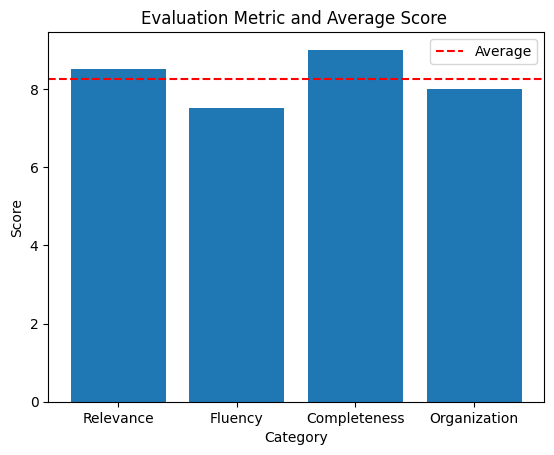

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Relevance', 'Fluency', 'Completeness', 'Organization']
scores = [8.5,7.5,9,8]

# Calculate average
average = np.mean(scores)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the bar chart
ax.bar(categories, scores)

# Plot the average line
ax.axhline(y=average, color='r', linestyle='--', label='Average')

# Set title and labels
ax.set_title('Evaluation Metric and Average Score ')
ax.set_xlabel('Category')
ax.set_ylabel('Score')

# Legend
ax.legend()

# Show the plot
plt.show()